## Character Clasiffier

### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Flatten, Dropout
from keras.applications.vgg16 import preprocess_input
from keras.utils import image_dataset_from_directory, plot_model
import tensorflow as tf
import cv2

2024-11-13 16:30:28.182204: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 16:30:28.187507: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-13 16:30:28.203266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731526228.229467   19421 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731526228.235860   19421 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-13 16:30:28.259285: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

### Constants

In [2]:
DATASET_PATH = "../data/"
IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)
BATCH_SIZE = 32 

### Funciones

In [3]:
def preprocess_input_fn(image, label):
    image = preprocess_input(image)
    return image, label

### Data preparation

In [5]:
datasets = ['train', 'val', 'test']
ds = []

for dataset in datasets:
    data = image_dataset_from_directory(
        DATASET_PATH + dataset,
        seed=1337,
        labels='inferred',
        label_mode='categorical',
        shuffle=True,
        image_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
    )
    ds.append(data)

train_ds = ds[0].map(lambda x,y: (x/255, y)).map(preprocess_input_fn) # Scale de input by 255 and preprocess it for vgg16
val_ds   = ds[1].map(lambda x,y: (x/255, y)).map(preprocess_input_fn)
test_ds  = ds[2].map(lambda x,y: (x/255, y)).map(preprocess_input_fn)

Found 10239 files belonging to 63 classes.
Found 3511 files belonging to 63 classes.
Found 926 files belonging to 50 classes.


### Model Architecture

In [6]:
def create_classifier(input_shape, n_classes, optimizer, fine_tune=0):
    """
    Compiles a model integrated with VGG16 pretrained layers
    
    input_shape: tuple - the shape of input images (width, height, channels)
    n_classes: int - number of classes for the output layer
    optimizer: string - instantiated optimizer to use for training. Defaults to 'RMSProp'
    fine_tune: int - The number of pre-trained layers to unfreeze.
                If set to 0, all pretrained layers will freeze during training
    """

    # Pretrained convolutional layers are loaded using the Imagenet weights.
    # Include_top is set to False, in order to exclude the model's fully-connected layers.
    conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)
    
    # Defines how many layers to freeze during training.
    # Layers in the convolutional base are switched from trainable to non-trainable
    # depending on the size of the fine-tuning parameter.
    if fine_tune > 0:
        for layer in conv_base.layers[:-fine_tune]:
            layer.trainable = False
    else:
        for layer in conv_base.layers:
            layer.trainable = False

    # Create a new 'top' of the model (i.e. fully-connected layers).
    # This is 'bootstrapping' a new top_model onto the pretrained layers.
    top_model = conv_base.output
    top_model = Flatten(name="flatten")(top_model)
    top_model = Dense(4096, activation='relu')(top_model)
    top_model = Dense(1024, activation='relu')(top_model)
    top_model = Dense(256, activation='relu')(top_model)
    top_model = Dropout(0.2)(top_model)
    output_layer = Dense(n_classes, activation='softmax')(top_model)
    
    # Group the convolutional base and new fully-connected layers into a Model object.
    model = Model(inputs=conv_base.input, outputs=output_layer)

    # Compiles the model for training.
    model.compile(optimizer=optimizer, 
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [ ]:
n_classes = len(os.listdir(DATASET_PATH + 'train'))
model = create_classifier(input_shape = INPUT_SHAPE, n_classes=n_classes, optimizer=Adam(learning_rate=0.001))
# plot_model(model, show_shapes=True)

### Training

In [8]:
hist = model.fit(
    train_ds,
    epochs=25,
    validation_data=val_ds
)

2024-11-13 16:33:50.310231: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.
2024-11-13 16:33:51.339907: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 411041792 exceeds 10% of free system memory.


  1/320 ━━━━━━━━━━━━━━━━━━━━ 1:07:34 13s/step - accuracy: 0.0000e+00 - loss: 6.0273

KeyboardInterrupt: 

In [22]:
model.save('model.keras')

In [ ]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

### Testing

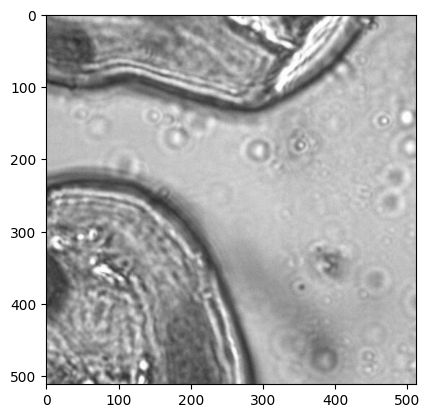

In [26]:
img = cv2.imread('../data/test/331_0_1024.png')
plt.imshow(img)
plt.show()

In [27]:
resize = tf.image.resize(img, IMAGE_SIZE)
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 581ms/step


In [28]:
yhat

array([[0.01053352, 0.44072196, 0.5487445 ]], dtype=float32)